In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import scipy.stats as st
from scipy.optimize import minimize
import math
from multiprocessing import Pool
import emcee
import seaborn as sns
import pandas as pd # Import pandas to handle the data set
import itertools

def Omega_k(Omega_m0, Omega_l0, Omega_r0):
    Omega_k0 = 1 - Omega_m0 - Omega_l0 - Omega_r0
    return Omega_k0

def E(x, Omega_m0):
    Omega_r0 = 0
    omega_l0 = Omega_m0 - 1    
    return np.sqrt(Omega_m0*(1+x)**3 + Omega_l0)

def IntFunct(x, Omega_m0):
    return E(x, Omega_m0)**(-1)

def integral(z, Omega_m0):
    return integrate.quad(IntFunct,0, z, args=(Omega_m0),epsabs=1.49e-4, epsrel=1.49e-03,full_output = 1)[0]

def distancia_luminosidad(z, h0, Omega_m0):
    
    c = 3 * 10**5 # km / s
    intl = integral(z, Omega_m0) 
    d_L = c * (1 + z) * intl / h0 # solo el caso plano
    return d_L

def mod_dist(z, h0, Omega_m0):
    
    c = 3 * 10**5 # km / s
    intl = integral(z, Omega_m0) 
    d_L = c * (1 + z) * intl / h0 # solo el caso plano
    return -5+5*np.log10(d_L*10**6)

mod_dist_vec = np.vectorize(mod_dist)

<ErrorbarContainer object of 3 artists>

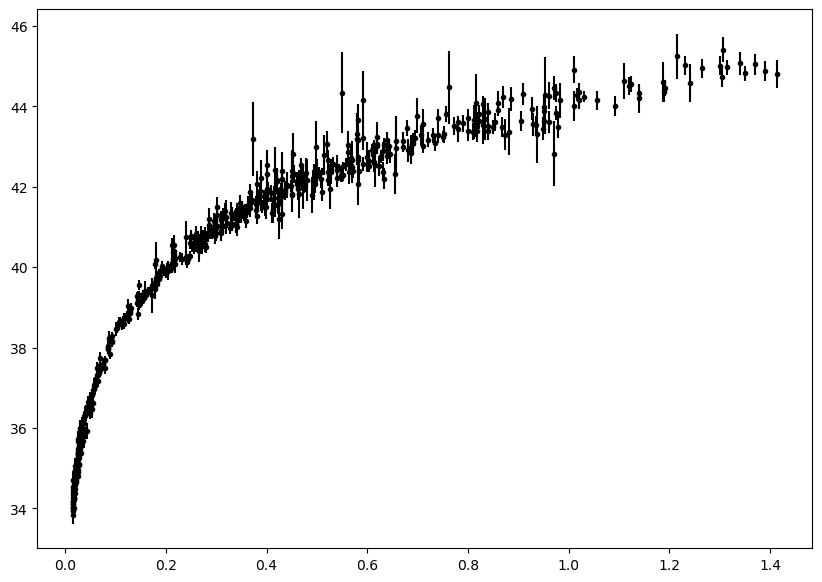

In [2]:
z_datos = np.genfromtxt("datos.csv", delimiter = ";", usecols = 0)
mu_datos = np.genfromtxt("datos.csv", delimiter = ";", usecols = 1)
mu_error_datos = np.genfromtxt("datos.csv", delimiter = ";", usecols = 2)

z_datos_ordenado, mu_datos_ordenado, mu_error_datos_ordenado = zip(*sorted(zip(z_datos, mu_datos, mu_error_datos)))
#print(z_datos_ordenado)
plt.figure(figsize=(10,7))
plt.errorbar(z_datos_ordenado, mu_datos_ordenado, yerr=mu_error_datos_ordenado, fmt = ".k")

# Cosmology Tables-- Data to Perform Your Own Fits
**Union Compilation Magnitude vs. Redshift Table**

An ASCII table with tab-separated columns: Supernova Name, Redshift, Distance Modulus, and Distance Modulus Error. For Union2.1, there is an additional column for the probability that the supernova was hosted by a low-mass galaxy. 


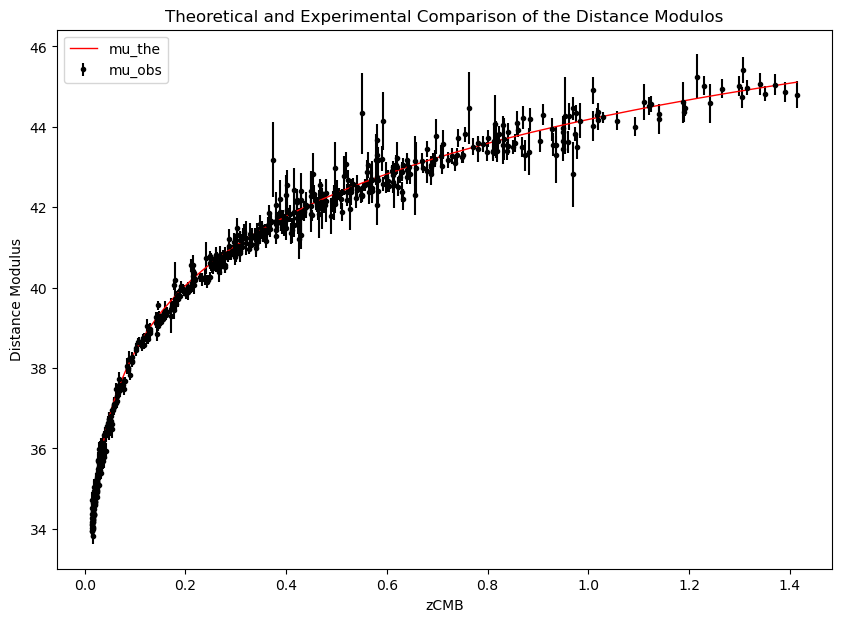

In [3]:
Omega_r0 = 0.0
Omega_m0 = 0.31
Omega_l0 = 0.69
h0 = 67 # km / s * Mpc

# Plot the theoretical experimental comparison of the distance modulos
plt.figure(figsize=(10,7))
# Plot the error bars
plt.errorbar(z_datos, mu_datos, yerr=mu_error_datos, fmt = ".k")
# Plot the true line
mu_theo=[mod_dist(z, h0, Omega_m0) for z in z_datos_ordenado]
plt.plot(z_datos_ordenado, mu_theo, "r", lw=1)
plt.title("Theoretical and Experimental Comparison of the Distance Modulos")
legend = ("mu_the","mu_obs")
plt.legend(legend)
plt.xlabel("zCMB")
plt.ylabel("Distance Modulus")
plt.savefig('dist_modulus.png')

In [4]:
def log_likelihood(theta, z, distancia, yerr):
    h0, Omega_m0 = theta # Parámetros a minimizar
    Omega_l0 = 1 - Omega_m0
    Omega_r0 = 0
    model = mod_dist_vec(z, h0, Omega_m0)
    sigma2 = np.array(yerr)**2
    return -0.5 * np.sum((distancia - model) ** 2 / sigma2)

def log_prior(theta):
    h0, Omega_m0 = theta # Parámetros a minimizar
    if 50< h0 < 100 and 0 < Omega_m0 < 1: # and and 0.0 < Omega_m0+Omega_l0+Omega_k(Omega_m0, Omega_l0, Omega_r0) <= 1.0
        return 0.0
    return -np.inf

def condition(theta, z):
    H, Omega_m0 = theta
    Omega_l0 = 1 - Omega_m0
    z_max = np.max(z)
    result = Omega_m0*(1+z_max)**3  + Omega_k(Omega_m0, Omega_l0, Omega_r0)*(1+z_max)**2 + Omega_l0
    if result < 0:
        return -np.inf
    return result

def log_probability(theta, valores_z, distancia, error):
    if not np.isfinite(log_prior(theta)):
        lp = -np.inf
        return lp
    if not np.isfinite(condition(theta, valores_z)):
        lp = -np.inf
        return lp
    lp = 0.0
    Likelihood = log_likelihood(theta, valores_z, distancia, error) +lp
    return Likelihood # Si el valor de lp es finito, contruimos la funcion probabilidad

In [5]:
max_n = 10000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

h0_random = np.random.uniform(50, 100, 100)
omega_m_random = np.random.uniform(0, 1, 100)
pos = []
pos = np.column_stack((h0_random, omega_m_random)) # Escribe los 2 vectores como columnas
nwalkers, ndim = pos.shape  # nwalker y ndim toma el valor del número de filas y el número de columnas del vector "pos", respectivamente.



with Pool(processes=6) as pool:
    sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(z_datos_ordenado, mu_datos_ordenado, mu_error_datos_ordenado))
    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(pos, iterations=max_n, progress=True):
        # Only check convergence every 100 steps
        if sampler.iteration % 100:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau
        n = 100 * np.arange(1, index + 1)
        y = autocorr[:index]
        plt.plot(n, n / 100.0, "--k")
        plt.plot(n, y)
        plt.xlim(0, n.max())
        plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
        plt.xlabel("number of steps")
        plt.ylabel(r"mean $\hat{\tau}$")
        file_name_fig = 'autocorrelation.png'
        plt.savefig(file_name_fig)
        plt.close()

 31%|███       | 3100/10000 [3:59:58<8:54:08,  4.64s/it] 


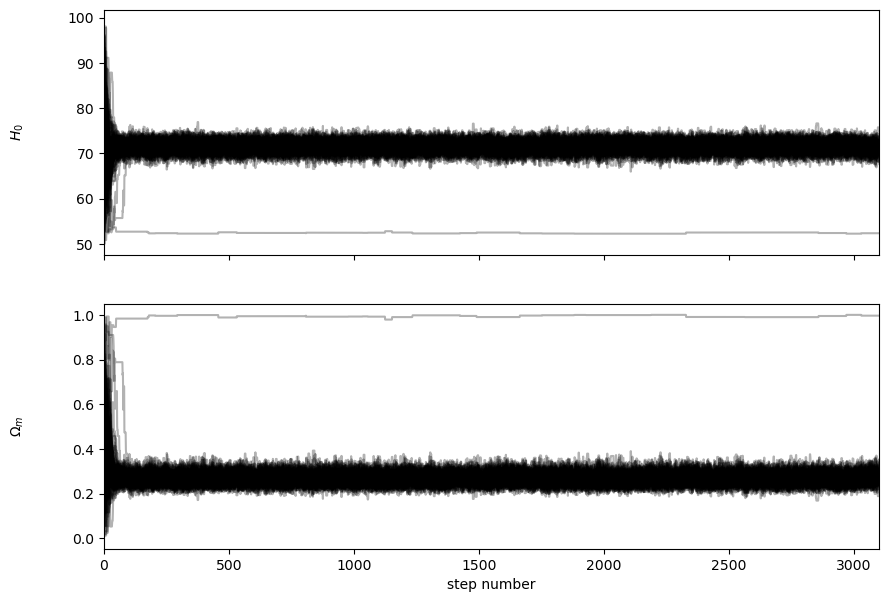

In [6]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$H_0$", "$\Omega_m$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [2]:
tau = sampler.get_autocorr_time()  # autocorrelation
print(tau)
print("-----")
burnin = int(2 * np.max(tau))  # burn in phase
thin = int(0.5 * np.min(tau))  #
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print(flat_samples)
np.savetxt('flat_samples_union_flat.csv', flat_samples, delimiter = ',')


NameError: name 'sampler' is not defined

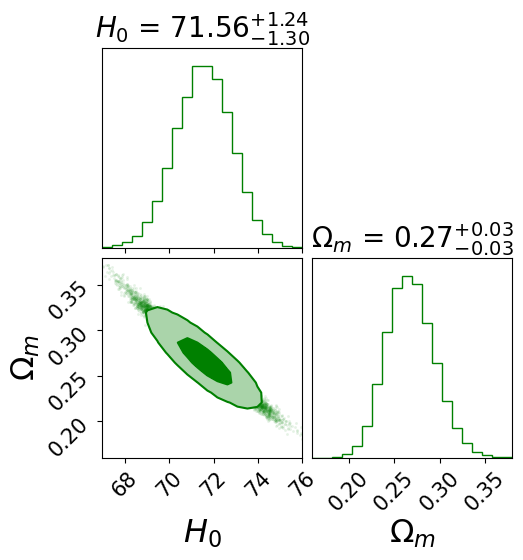

In [2]:
import corner
# Parámetros del modelo
labels = ["$H_0$", "$\Omega_m$"]
flat_samples = np.genfromtxt('flat_samples_union_flat.csv', delimiter = ',')
fig = corner.corner(flat_samples, labels=labels,fill_contours=True,bins=20, color='green', show_titles=True,smooth=1.0, 
                        label_kwargs={"fontsize": 23},title_kwargs={"fontsize": 20}, tick_kwargs={"fontsize": 15},
                        levels=(1-np.exp(-0.5),1-np.exp(-2.0)), range = [(67, 76), (0.16, 0.38)])

fontsize = 15
for ax in fig.get_axes():
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
fig.savefig('corner_union_noflat.pdf')

In [4]:
from IPython.display import display, Math

results = []
for i in range(2):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    print(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    append = [mcmc[1], q[0], q[1]]
    results.append(append)
    display(Math(txt))
np.savetxt('Resultados_union_flat.csv', results, delimiter=',')
    

[70.25886285 71.55826528 72.80176317]


<IPython.core.display.Math object>

[0.24272995 0.26772998 0.29550314]


<IPython.core.display.Math object>